In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from matplotlib.ticker import MaxNLocator

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
stocks = pd.read_csv('StocksMcap.csv')
countries = pd.read_csv('CtryMcapIndex.csv')
sectors = pd.read_csv('IndMcapIndex.csv')

In [3]:
stocksT = stocks.transpose()
new_header = stocksT.iloc[0] #get the first row for the header
stocksT = stocksT[1:] #take the data less the header row
stocksT.columns = new_header #set the header row as the df header


countriesT = countries.transpose()
new_header = countriesT.iloc[0] #get the first row for the header
countriesT = countriesT[1:] #take the data less the header row
countriesT.columns = new_header #set the header row as the df header


sectorsT = sectors.transpose()
new_header = sectorsT.iloc[0] #get the first row for the header
sectorsT = sectorsT[1:] #take the data less the header row
sectorsT.columns = new_header #set the header row as the df header

sectorsT.head()

Unnamed: 0,Africa: Homebuilding,Agriculture,Austria: Homebuilding,Brazil: Homebuilding,Canada: Homebuilding,Chemicals,China: Homebuilding,Commercial Services,Communications,Consumer Durables,...,Pulp & Paper,Retail Trade,SouthAmerica: Homebuilding,Spain: Homebuilding,Switzerland: Homebuilding,Technology Services,Transportation,United Kingdom: Homebuilding,United States: Homebuilding,Water Utilities
X20001229,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
X20010102,1,0.995592,1.0234,1,1,0.999192,1.01157,0.995158,0.999395,0.998553,...,1.00029,0.998459,1,1.01348,1.00796,0.962029,0.993736,0.985401,0.992848,0.995069
X20010103,1,0.984589,0.995764,1,1,1.00077,1.01274,1.00052,1.00351,1.00286,...,0.979524,1.04694,1,1.01166,0.990971,1.0497,1.00733,0.987827,1.11154,1.00532
X20010104,1,0.981517,0.988716,1,1,1.00699,1.02065,1.01599,1.03887,1.01353,...,0.987474,1.03219,1,1.02114,0.994667,1.04812,1.01604,0.994783,1.12281,0.952075
X20010105,1,0.976032,1.02211,1,1,1.00235,1.02335,1.00991,1.0487,1.02722,...,0.986077,1.00953,1,1.06133,0.966817,1.02864,1.01467,1.00572,1.08433,0.957838


In [4]:
#don't run
#trimmer = lambda x: x[1:] 
#stocksT = stocksT.reset_index() #reindex so we can manipultate the date field as a column
#stocksT['index'] = stocksT['index'].apply(trimmer) #remove the trailing X
#stocksT['index'] = pd.to_datetime(stocksT['index']) #convert the index col to datetime type
#stocksT = stocksT.set_index('index') #restore the index column as the actual dataframe index
#stocksT = stocksT[1:]
#stocksT.head()

In [5]:
trimmer = lambda x: x[1:] 

def dateconv(dataframe,func):
    dataframe = dataframe.reset_index() #reindex so we can manipultate the date field as a column
    dataframe['index'] = dataframe['index'].apply(func) #remove the trailing X
    dataframe['index'] = pd.to_datetime(dataframe['index']) #convert the index col to datetime type
    dataframe = dataframe.set_index('index') #restore the index column as the actual dataframe index
    dataframe = dataframe[1:]
    return dataframe
    
countriesT = dateconv(countriesT,trimmer)
sectorsT = dateconv(sectorsT,trimmer)
stocksT = dateconv(stocksT,trimmer)

countriesT.head()


Unnamed: 0,Africa,Austria,Belgium,Brazil,Canada,China,EmergingEurope,FarEast,France,Germany,...,MiddleEast,Netherlands,Nordic,Other Country,Portugal,SouthAmerica,Spain,Switzerland,United Kingdom,United States
index,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.993572,0.998283,1.01151,0.991828,1.00153,1.01202,1.00279,1.0031,0.992324,0.987278,...,1.0006,1.00345,0.994549,0.97088,1.01972,0.997389,1.01492,1.00207,0.999694,0.9718
2001-01-03,0.978314,0.979304,0.916723,1.05041,1.01344,1.0057,0.971203,0.999485,0.973589,1.01225,...,0.990348,0.991386,0.932222,0.99551,1.00779,1.01167,1.04627,0.996482,0.979403,1.01749
2001-01-04,0.995879,0.975337,0.917264,1.0478,0.994964,1.03093,1.02519,1.03124,0.986468,0.997589,...,0.977641,0.996385,1.00953,0.981467,1.02577,1.02897,1.07972,0.987819,0.979615,1.00336
2001-01-05,0.993199,0.987602,0.909143,1.02654,0.983888,1.03965,1.01859,1.05452,0.98606,1.01173,...,0.980924,1.00342,1.01058,0.967472,1.00475,1.03017,1.09029,0.97405,0.983876,0.978235
2001-01-08,0.988052,0.993214,0.91227,1.02634,0.986449,1.03394,1.02862,1.05466,0.977664,1.00502,...,0.979896,0.999893,0.989583,0.954386,0.982089,1.02834,1.08211,0.969039,0.976709,0.977429


In [6]:
def logrets(dataframe):
    dataframe = dataframe.dropna()
    rets = np.log(dataframe.astype('float') / dataframe.astype('float').shift(1))
    return rets

countriesT = logrets(countriesT)
sectorsT = logrets(sectorsT)
stocksT = logrets(stocksT)
stocksT.head()


Unnamed: 0,7332687^,B3B5J07^,6900212^,B3P2CN8^,B1VZ431^,2816023^,2267171^,B39J2M4^,4031879^,B15RZR4^,2288406^
index,,,,,,,,,,,
2011-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-14,0.020197,0.006515,-0.054451,0.044362,0.002061,0.022902,-0.001140,-0.000470,0.016039,-0.032435,0.007749
2011-10-17,-0.013906,-0.063673,-0.004306,-0.007523,-0.031367,-0.053664,-0.012911,-0.002188,-0.036259,-0.068208,-0.040100
2011-10-18,0.014317,0.050601,0.009218,0.003175,0.032396,0.037275,0.006620,-0.009580,-0.026697,0.057158,0.038198
2011-10-19,0.010404,-0.036855,-0.015482,-0.019605,-0.011896,-0.019065,0.004294,0.025317,0.031288,-0.007435,-0.012330


In [7]:
# merge the dataframes together, use left join to only match indicies where the stocks have values
print(stocksT.shape, sectorsT.shape, countriesT.shape)
combo = stocksT.join([sectorsT,countriesT],how='left')
#check that our dimensions make sense for PCA, number of examples x number of features
print(combo.shape)
combo.head()

(1520, 11) (4213, 54) (4213, 25)
(1520, 90)


Unnamed: 0,7332687^,B3B5J07^,6900212^,B3P2CN8^,B1VZ431^,2816023^,2267171^,B39J2M4^,4031879^,B15RZR4^,...,MiddleEast,Netherlands,Nordic,Other Country,Portugal,SouthAmerica,Spain,Switzerland,United Kingdom,United States
index,,,,,,,,,,,,,,,,,,,,,
2011-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000809,-0.002303,-0.019856,-0.003240,-0.021689,-0.003692,-0.009300,-0.014683,-0.007266,0.000373
2011-10-14,0.020197,0.006515,-0.054451,0.044362,0.002061,0.022902,-0.001140,-0.000470,0.016039,-0.032435,...,0.000102,0.024136,0.029461,0.009545,0.025448,0.014291,0.019845,0.015486,0.015523,0.018139
2011-10-17,-0.013906,-0.063673,-0.004306,-0.007523,-0.031367,-0.053664,-0.012911,-0.002188,-0.036259,-0.068208,...,0.001363,-0.010708,-0.022656,-0.009525,-0.023044,0.000628,-0.016241,-0.013272,-0.009547,-0.018612
2011-10-18,0.014317,0.050601,0.009218,0.003175,0.032396,0.037275,0.006620,-0.009580,-0.026697,0.057158,...,0.000086,-0.004929,0.000914,-0.006821,-0.001083,-0.002459,-0.013630,-0.008060,-0.010261,0.016819
2011-10-19,0.010404,-0.036855,-0.015482,-0.019605,-0.011896,-0.019065,0.004294,0.025317,0.031288,-0.007435,...,-0.005619,0.015216,0.003501,-0.001433,0.006036,0.003837,0.008559,0.004891,0.015290,-0.012701


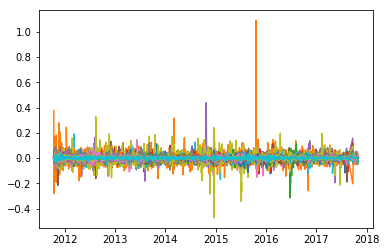

In [18]:
plt.plot(combo)
plt.show()

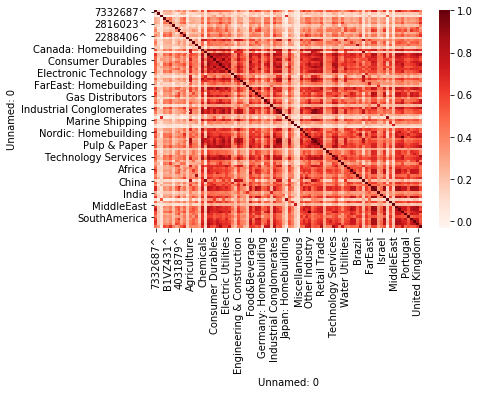

In [9]:
#calculate the pearson correlation matrix over the time frame - this is normalised with the std dev
ax = sns.heatmap(combo.dropna().corr(),cmap="Reds")
plt.show()

In [9]:
#manually calculate correlation coefficents - normalise by stdev.
combo = combo.dropna()
m = combo.mean(axis=0)
s = combo.std(ddof=1, axis=0)
 
# normalised time-series as an input for PCA
combo_pca = (combo - m)/s
 
c = np.cov(combo_pca.values.T)     # covariance matrix     # covariance matrix
co = np.corrcoef(combo_pca.values.T) 


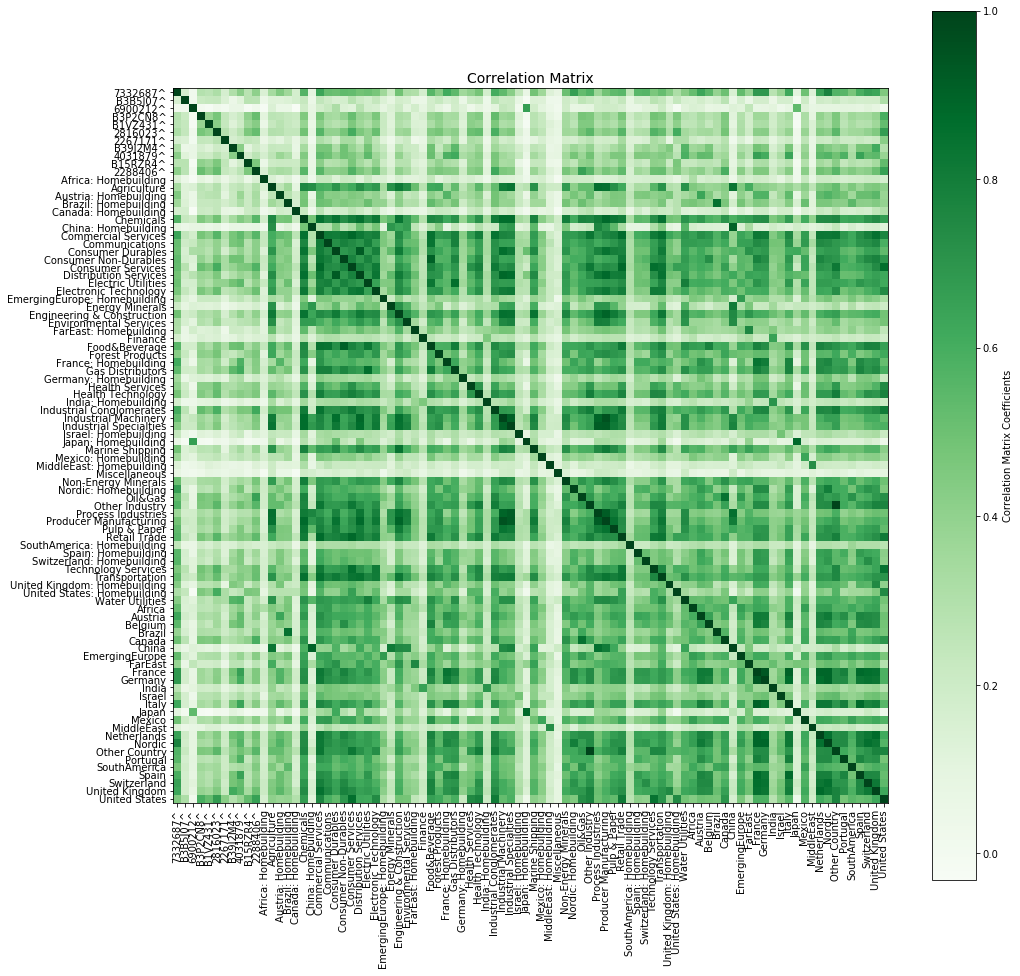

In [11]:
#create a correlation heatmap
tickers = list(combo.columns)
 
plt.figure(figsize=(16,16))
plt.imshow(co, cmap="Greens", interpolation="nearest")
cb = plt.colorbar()
cb.set_label("Correlation Matrix Coefficients")
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
plt.yticks(np.arange(len(tickers)), tickers)
plt.show()

In [17]:
#create an interactive heatmap
tickers = list(combo.columns)
trace = go.Heatmap(z=co.tolist(),x=tickers,y=tickers,colorscale='Viridis')
data=[trace]
iplot(data)


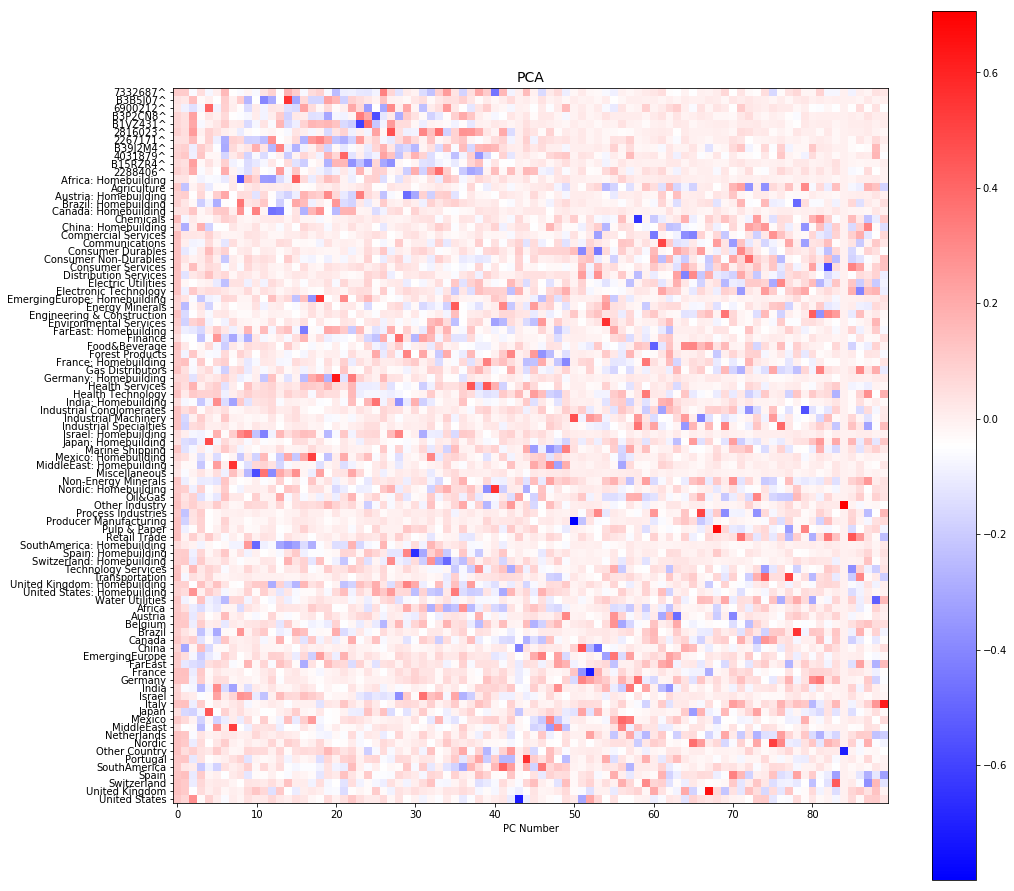

In [12]:
# perform PCA
eig_vals, eig_vecs = np.linalg.eig(c)  
 
ax = plt.figure(figsize=(16,16)).gca()
plt.imshow(eig_vecs, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [23]:
#can also use SVD to determine PC's

scaler = StandardScaler()
scaler.fit(combo.dropna())
X=scaler.transform(combo.dropna())    
pca = PCA()
x_new = pca.fit_transform(combo.dropna())

1.0


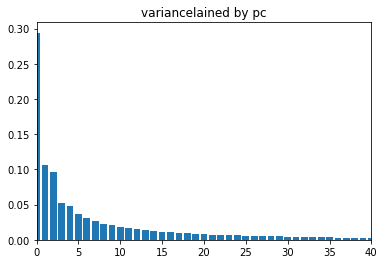

In [28]:
#plot contribution of each PC to the total variance

plt.bar(range(90),pca.explained_variance_ratio_)
plt.title('variancelained by pc')
plt.xlim([0,40])
print(pca.explained_variance_ratio_.sum())
plt.show()

In [108]:
#we need a labels array to categorise our points as a sector,industry or stock
#labels array needs to be (num samples x 1)
labels = []
for i in range (len(combo.columns)):
    if combo.columns[i] in stocksT.columns:
        labels.append('r')
    elif combo.columns[i] in sectorsT.columns:
        labels.append('b')
    elif combo.columns[i] in countriesT.columns:
        labels.append('g')


In [138]:
xs = x_new[:,1]
ys = x_new[:,2]

scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

plt.scatter(xs*scalex,ys*scaley,c=labels)
plt.xlim([-0.1,0.2])
plt.ylim([-0.2,0.2])



(-0.2, 0.2)

In [113]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [116]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(90,1), 
                      eig_pairs[1][1].reshape(90,1)))

#print('Matrix W:\n', matrix_w)

In [137]:
Y = X.dot(matrix_w)
Y[0:len(stocksT.columns),0]
X.shape

(1500, 90)

In [ ]:
trace0 = go.Scatter(
    x = Y[,0],
    y = Y[:,1],
    name = 'Above',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)'
       
    )
)

data = Data([trace0])
layout = Layout(showlegend=True,
                scene=Scene(xaxis=XAxis(title='PC1'),
                yaxis=YAxis(title='PC2'),))

fig = Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
combo_pca

In [ ]:
#dfP = stocksT[(stocksT.index >= "2017-03-01") & (stocksT.index <= "2017-03-31")]

#calculate the log returns
dfP = stocksT.dropna()
dflr = np.log(dfP.astype('float') / dfP.astype('float').shift(1))
dflr.head()

In [ ]:
# choose PC-k numbers
k1 = -1  # the last PC column in 'v' PCA matrix
k2 = -2  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()
 
# compute the distance from (0,0) point
dist = []
for i in range(eig_vecs.shape[0]):
    x = eig_vecs[i,k1]
    y = eig_vecs[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color="grey")
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
plt.show()

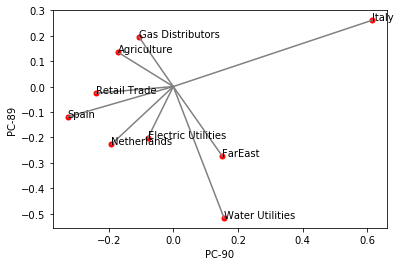

In [147]:
quar = []
for i in range(eig_vecs.shape[0]):
    x = eig_vecs[i,k1]
    y = eig_vecs[i,k2]
    d = np.sqrt(x**2 + y**2)
    if(d > np.mean(dist) + np.std(dist, ddof=1)):
        plt.plot(x, y, '.r', markersize=10)
        plt.plot([0,x], [0,y], '-', color="grey")
        if((x > 0) and (y > 0)):
            quar.append((i, 1))
        elif((x < 0) and (y > 0)):
            quar.append((i, 2))
        elif((x < 0) and (y < 0)):
            quar.append((i, 3))
        elif((x > 0) and (y < 0)):
            quar.append((i, 4))
        plt.text(x, y, tickers[i], color='k')
 
plt.xlabel("PC-" + str(len(tickers)+k1+1))
plt.ylabel("PC-" + str(len(tickers)+k2+1))

plt.show()

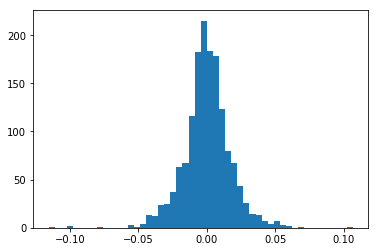

In [10]:
#plot the distribution of returns - if it's normal then its likely stationary
plt.hist(dflr.iloc[:,10].dropna(),bins=50)
plt.show()

In [11]:
#perform ADF test to check for stationary in data - very large neagtive so reject null hyp - we have stationarity
result = adfuller(dflr.iloc[:,10].dropna())
result[0]

-21.15407713114617

In [12]:
dflr.corr()

Unnamed: 0,7332687^,B3B5J07^,6900212^,B3P2CN8^,B1VZ431^,2816023^,2267171^,B39J2M4^,4031879^,B15RZR4^,2288406^
Unnamed: 0,,,,,,,,,,,
7332687^,1.000000,0.158146,0.014036,0.287733,0.270609,0.313332,0.161646,0.304974,0.418383,0.274289,0.408528
B3B5J07^,0.158146,1.000000,0.015962,0.217305,0.230950,0.236623,0.143261,0.054921,0.119223,0.272663,0.269250
6900212^,0.014036,0.015962,1.000000,0.003814,-0.022027,0.026350,0.007771,0.068592,0.067176,-0.018672,0.021515
B3P2CN8^,0.287733,0.217305,0.003814,1.000000,0.380808,0.469046,0.238434,0.165455,0.218243,0.400781,0.507797
B1VZ431^,0.270609,0.230950,-0.022027,0.380808,1.000000,0.422197,0.228528,0.127214,0.200969,0.370849,0.429918
2816023^,0.313332,0.236623,0.026350,0.469046,0.422197,1.000000,0.282934,0.194916,0.271993,0.459223,0.520575
2267171^,0.161646,0.143261,0.007771,0.238434,0.228528,0.282934,1.000000,0.164164,0.204047,0.246744,0.230129
B39J2M4^,0.304974,0.054921,0.068592,0.165455,0.127214,0.194916,0.164164,1.000000,0.421990,0.102959,0.192625
4031879^,0.418383,0.119223,0.067176,0.218243,0.200969,0.271993,0.204047,0.421990,1.000000,0.186986,0.263413


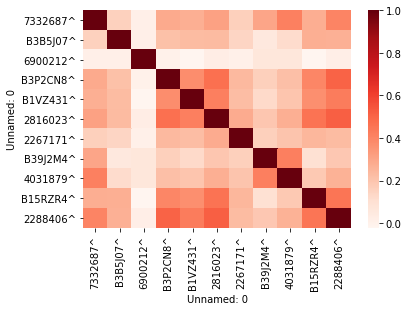

In [13]:
#calculate the pearson correlation matrix over the time frame - this is normalised with the std dev
ax = sns.heatmap(dflr.dropna().corr(),cmap="Reds")
plt.show()

In [14]:
dflr = dflr.dropna()
m = dflr.mean(axis=0)
s = dflr.std(ddof=1, axis=0)
 
# normalised time-series as an input for PCA
dflr_pca = (dflr - m)/s
 
c = np.cov(dflr_pca.values.T)     # covariance matrix     # covariance matrix
co = np.corrcoef(dflr_pca.values.T) 


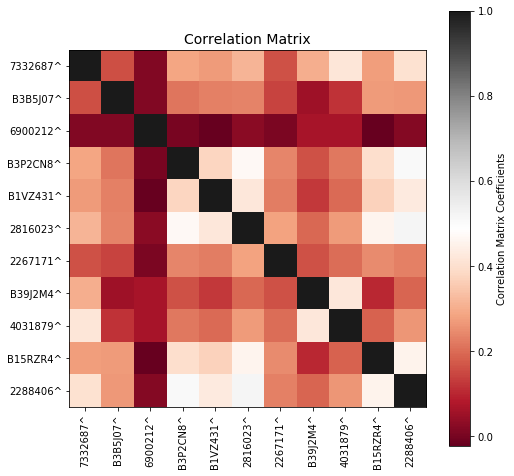

In [15]:
tickers = list(dflr.columns)
 
plt.figure(figsize=(8,8))
plt.imshow(co, cmap="RdGy", interpolation="nearest")
cb = plt.colorbar()
cb.set_label("Correlation Matrix Coefficients")
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
plt.yticks(np.arange(len(tickers)), tickers)
plt.show()

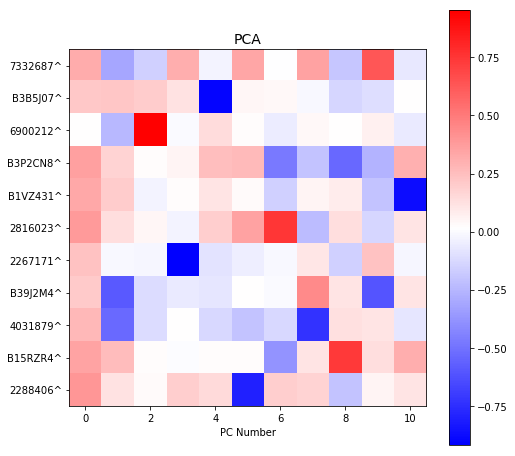

In [16]:
# perform PCA
w, v = np.linalg.eig(c)  
 
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(v, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [17]:

eig_vals, eig_vecs = np.linalg.eig(c)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[  3.16669907e-01  -3.05464682e-01  -1.56321940e-01   3.15936315e-01
   -2.45054599e-02   3.41058603e-01   1.61004417e-02   3.53988779e-01
   -1.89469616e-01   6.32000078e-01  -6.59362717e-02]
 [  2.21291610e-01   2.25865376e-01   2.02952829e-01   1.19435961e-01
   -9.00836918e-01   5.18197765e-02   4.15262370e-02  -9.89136034e-03
   -1.29546555e-01  -1.06143270e-01   2.22854705e-02]
 [  1.88313455e-02  -2.44325915e-01   9.51110672e-01   2.52961095e-03
    1.43623623e-01   2.55821813e-02  -5.05728361e-02   4.15187707e-02
    1.83922548e-02   7.53861585e-02  -6.12156625e-02]
 [  3.60516968e-01   1.71837244e-01   2.52937916e-02   5.41112380e-02
    2.55594826e-01   2.68269874e-01  -4.65343444e-01  -1.96287559e-01
   -5.34162229e-01  -2.60001665e-01   3.02705725e-01]
 [  3.34541947e-01   2.03510148e-01  -2.54265133e-02   2.61188621e-02
    1.15067878e-01   3.89653863e-02  -1.53988873e-01   5.39750325e-02
    8.41834539e-02  -1.97080228e-01  -8.70645931e-01]
 [  3.87667068e-

In [18]:
u,s,v = np.linalg.svd(c)


In [19]:
scaler = StandardScaler()
scaler.fit(dflr)
X=scaler.transform(dflr)    
pca = PCA()
x_new = pca.fit_transform(dflr)

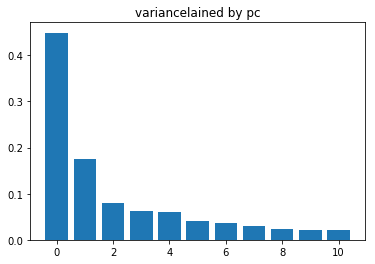

In [20]:
#plot contribution of each PC to the total variance
plt.bar(range(11),pca.explained_variance_ratio_)
plt.title('variancelained by pc')
plt.show()

In [21]:
x_new[:,0:2]

array([[ 0.01020912, -0.01297173],
       [-0.09911568,  0.06758165],
       [ 0.07310088, -0.03793354],
       ..., 
       [-0.02041936, -0.0058155 ],
       [-0.05350745,  0.00463278],
       [ 0.01476514, -0.0160537 ]])

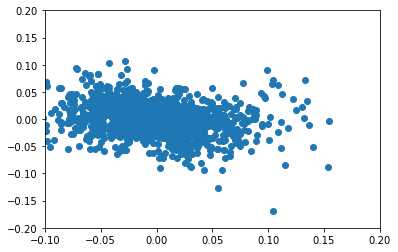

In [22]:
xs = x_new[:,0]
ys = x_new[:,1]

scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

plt.scatter(xs,ys)
plt.xlim([-0.1,0.2])
plt.ylim([-0.2,0.2])

plt.show()

In [281]:
xs.shape

(1519,)

In [286]:
dflr.shape

(1519, 11)